In [10]:
import os
import torch
import random
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [11]:
# Set seed untuk reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [12]:
    data_dir = 'dataset/train'

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])
    ])

    dataset = ImageFolder(data_dir, transform=transform)
    class_names = dataset.classes
    print(f"Class: {class_names}, Jumlah data: {len(dataset)}")

Class: ['Segar', 'TidakSegar'], Jumlah data: 5696


In [13]:
# --- Import yang dibutuhkan ---
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image

# --- Parameter normalisasi (samakan dengan yang dipakai di transforms.Normalize) ---
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

# --- Util: balikin normalisasi biar bisa ditampilkan normal (0..1) ---
def denormalisasi(img_t, mean=MEAN, std=STD):
    """
    img_t: Tensor CxHxW (float, sudah dinormalisasi)
    return: Tensor CxHxW (0..1) siap untuk plt.imshow
    """
    if isinstance(mean, list): mean = torch.tensor(mean)
    if isinstance(std, list):  std = torch.tensor(std)
    img = img_t.clone().detach()
    img = img * std.view(-1, 1, 1) + mean.view(-1, 1, 1)
    img = img.clamp(0, 1)
    return img

def tampilkan_grid(tensor_gambar, nrow=4, judul=None, ukuran=(8,8)):
    """
    tensor_gambar: Tensor NxCxHxW (nilai 0..1)
    """
    grid = make_grid(tensor_gambar, nrow=nrow, padding=2)
    plt.figure(figsize=ukuran)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    if judul:
        plt.title(judul)
    plt.axis('off')
    plt.show()

def tampilkan_dua_asli_dan_aug(dataset, class_names, idxs=[0,1], aug_per_gambar=12, nrow=6):
    """
    1) Menampilkan 2 foto asli (tanpa transform dataset)
    2) Menampilkan grid berisi beberapa hasil augmentasi untuk masing-masing foto
       (augmentasi diterapkan sesuai dataset.transform yang sudah kamu definisikan)
    """
    assert len(idxs) == 2, "Berikan tepat 2 indeks pada parameter idxs, misal [0,1]"
    # Ambil path & label dari ImageFolder
    (path1, label1) = dataset.samples[idxs[0]]
    (path2, label2) = dataset.samples[idxs[1]]

    # --- 1) Tampilkan 2 foto asli (PIL tanpa transform) ---
    pil1 = Image.open(path1).convert("RGB")
    pil2 = Image.open(path2).convert("RGB")

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(pil1)
    plt.title(f"Asli idx={idxs[0]} | Kelas: {class_names[label1]}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(pil2)
    plt.title(f"Asli idx={idxs[1]} | Kelas: {class_names[label2]}")
    plt.axis('off')
    plt.suptitle("Dua Foto Asli (tanpa augmentasi)")
    plt.tight_layout()
    plt.show()

    # --- 2) Buat beberapa variasi augmentasi untuk gambar ke-1 ---
    aug_list_1 = [dataset.transform(pil1) for _ in range(aug_per_gambar)]
    aug_denorm_1 = torch.stack([denormalisasi(t) for t in aug_list_1])
    tampilkan_grid(
        aug_denorm_1, 
        nrow=nrow, 
        judul=f"Augmentasi untuk idx={idxs[0]} (kelas: {class_names[label1]})"
    )

    # --- 3) Buat beberapa variasi augmentasi untuk gambar ke-2 ---
    aug_list_2 = [dataset.transform(pil2) for _ in range(aug_per_gambar)]
    aug_denorm_2 = torch.stack([denormalisasi(t) for t in aug_list_2])
    tampilkan_grid(
        aug_denorm_2, 
        nrow=nrow, 
        judul=f"Augmentasi untuk idx={idxs[1]} (kelas: {class_names[label2]})"
    )

# ===== Cara pakai (lanjutkan dari variabel dataset & class_names yang kamu punya) =====
# Tampilkan 2 foto asli (idx 0 dan 1), lalu masing-masing 12 variasi augmentasi (grid 6 kolom)
# tampilkan_dua_asli_dan_aug(dataset, class_names, idxs=[0,1], aug_per_gambar=12, nrow=6)


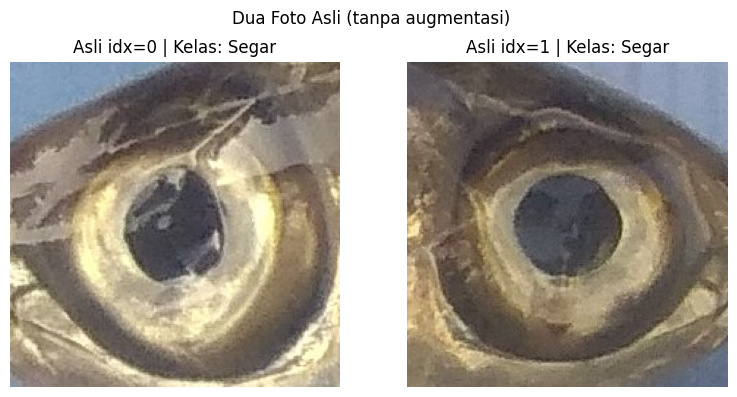

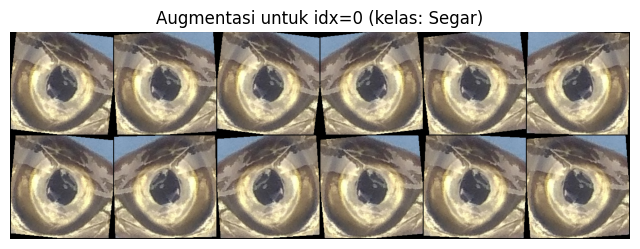

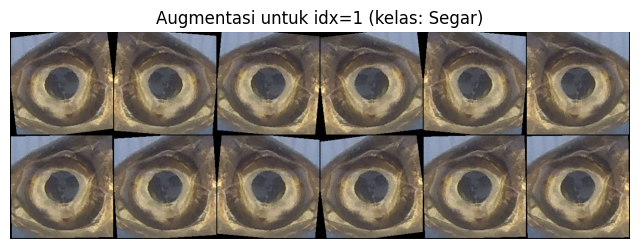

In [19]:


# Tampilkan 8 variasi augmentasi dari gambar ke-0
tampilkan_dua_asli_dan_aug(dataset, class_names, idxs=[0,1], aug_per_gambar=12, nrow=6)

In [15]:
targets = [label for _, label in dataset]
class_count = np.bincount(targets)
class_weights = 1. / class_count
sample_weights = [class_weights[label] for label in targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [16]:
batch_size = 32

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('tf_efficientnetv2_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)
model = model.to(device)

# Loss dan Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [18]:
train_acc_history = []
train_loss_history = []

def train_model(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        loop = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item(), acc=100*correct/total)
        
        epoch_loss = running_loss / len(loader)
        epoch_acc = correct / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        print(f"[{epoch+1}] Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}%")

train_model(model, train_loader, criterion, optimizer, epochs=30)

[1] Loss: 0.6261 | Acc: 64.26%


[2] Loss: 0.5171 | Acc: 75.11%


KeyboardInterrupt: 

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=class_names))

[[1979  880]
 [   3 2834]]
              precision    recall  f1-score   support

       Segar       1.00      0.69      0.82      2859
  TidakSegar       0.76      1.00      0.87      2837

    accuracy                           0.84      5696
   macro avg       0.88      0.85      0.84      5696
weighted avg       0.88      0.84      0.84      5696



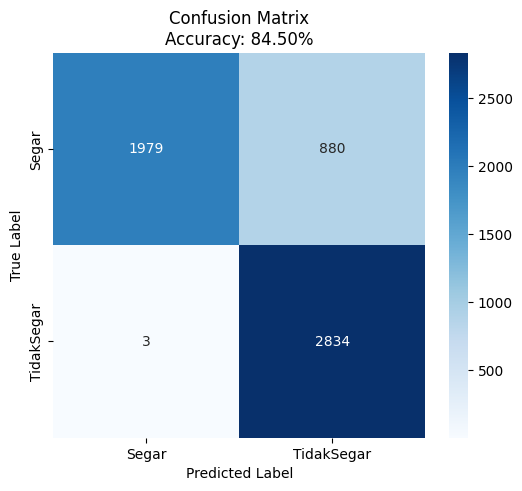

In [ ]:
from sklearn.metrics import accuracy_score  # Add this import if not already present
import seaborn as sns  # Fix: import seaborn

cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix\nAccuracy: {acc*100:.2f}%')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

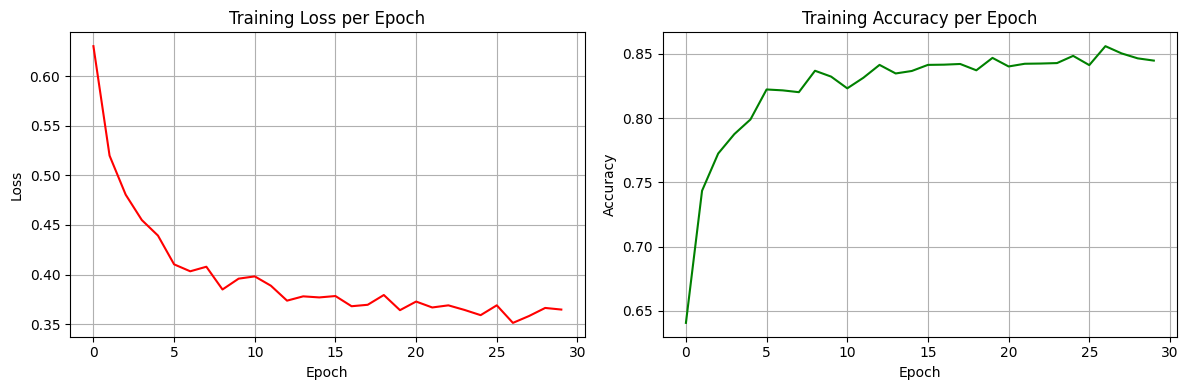

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Accuracy', color='green')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "efficientnetv2_ikan.pt")
print("Model disimpan sebagai efficientnetv2_ikan.pt")

Model disimpan sebagai efficientnetv2_ikan.pt
